In [1]:
import matplotlib.pyplot as plt
import yfinance as yf

# EDA

In [2]:
meta = yf.Ticker("META")
data = meta.history(period="max")
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-18 00:00:00-04:00,41.792365,44.724291,37.767179,37.995770,573576400,0.0,0.0
2012-05-21 00:00:00-04:00,36.306186,36.435390,32.797815,33.821503,168192700,0.0,0.0
2012-05-22 00:00:00-04:00,32.410203,33.384198,30.750434,30.810066,101786600,0.0,0.0
2012-05-23 00:00:00-04:00,31.177799,32.300874,31.167860,31.803938,73600000,0.0,0.0
2012-05-24 00:00:00-04:00,32.748121,33.006527,31.575351,32.827629,50237200,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-17 00:00:00-04:00,707.080017,718.539978,706.119995,716.919983,12232400,0.0,0.0
2025-10-20 00:00:00-04:00,721.190002,733.770020,720.179993,732.169983,8900200,0.0,0.0
2025-10-21 00:00:00-04:00,736.020020,738.500000,728.750000,733.270020,7647300,0.0,0.0


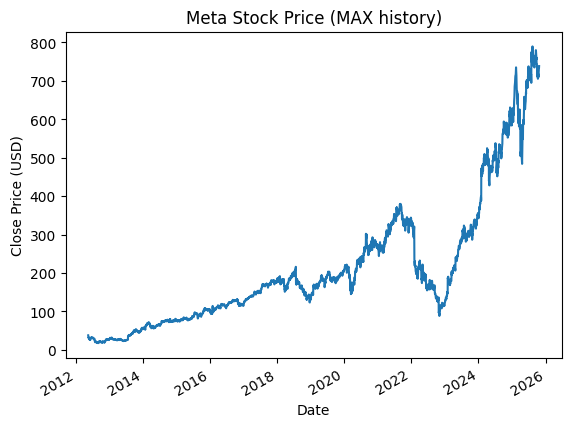

In [3]:
data['Close'].plot(title="Meta Stock Price (MAX history)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.show()

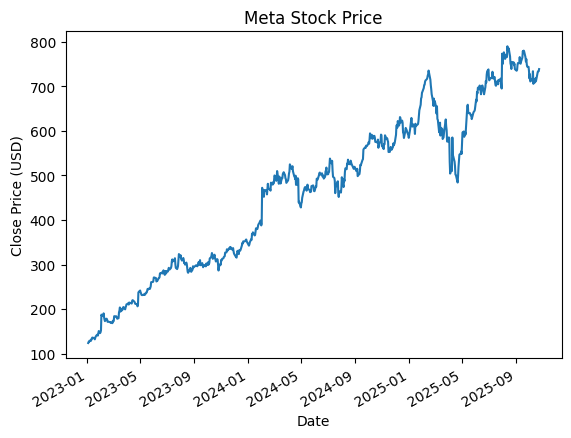

In [4]:
data = data[data.index > '2023-01-01']

data['Close'].plot(title="Meta Stock Price")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.show()

Сплит акций (stock split) — это дробление акций компании, при котором увеличивается их общее количество, а цена каждой акции пропорционально снижается, при этом рыночная капитализация компании и стоимость портфеля инвестора остаются неизменными.

In [5]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import pandas as pd

In [6]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

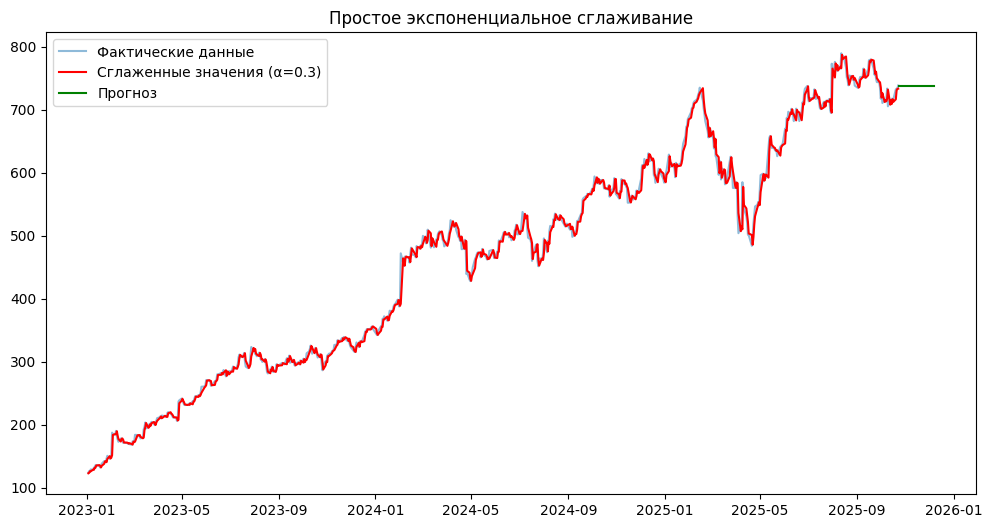

In [7]:
model = SimpleExpSmoothing(data["Close"], initialization_method="heuristic").fit(smoothing_level=0.9, optimized=False)
data["SES"] = model.fittedvalues

days_forward = 45
forecast = model.forecast(days_forward)

plt.figure(figsize=(12,6))
plt.plot(data.index, data["Close"], label="Фактические данные", alpha=0.5)
plt.plot(data.index, data["SES"], label="Сглаженные значения (α=0.3)", color="red")
plt.plot(pd.date_range(data.index[-1]+pd.Timedelta(days=1), periods=days_forward, freq="D"),
         forecast, label="Прогноз", color="green")
plt.legend()
plt.title("Простое экспоненциальное сглаживание")
plt.show()


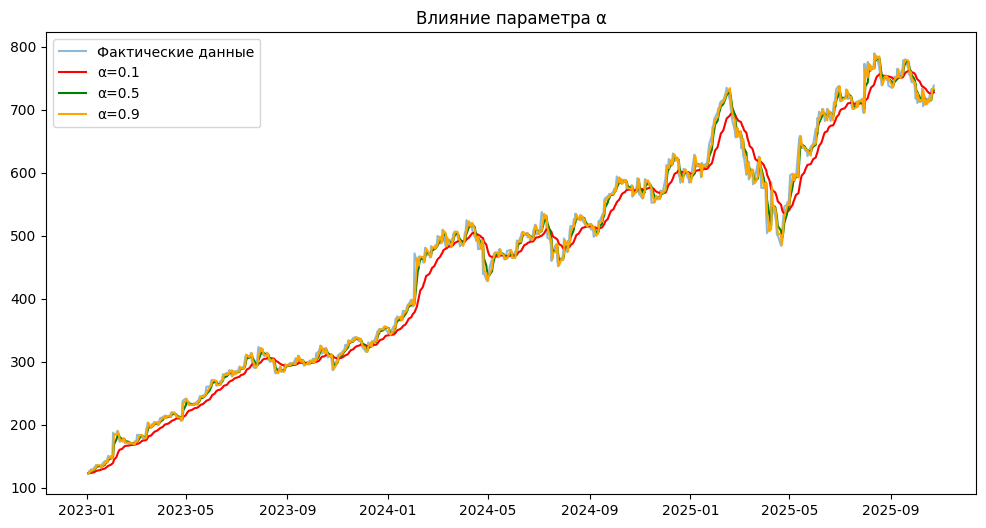

In [8]:
for alpha in [0.1, 0.5, 0.9]:
    model = SimpleExpSmoothing(data["Close"], initialization_method="heuristic").fit(smoothing_level=alpha, optimized=False)
    data[f"SES_{alpha}"] = model.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(data.index, data["Close"], label="Фактические данные", alpha=0.5)
plt.plot(data.index, data["SES_0.1"], label="α=0.1", color="red")
plt.plot(data.index, data["SES_0.5"], label="α=0.5", color="green")
plt.plot(data.index, data["SES_0.9"], label="α=0.9", color="orange")
plt.legend()
plt.title("Влияние параметра α")
plt.show()


=== Оптимальные параметры модели Хольта ===
α (smoothing_level) = 0.90261
β (smoothing_trend)  = 0.00000
Начальный уровень    = 123.13
Начальный тренд      = 0.8720


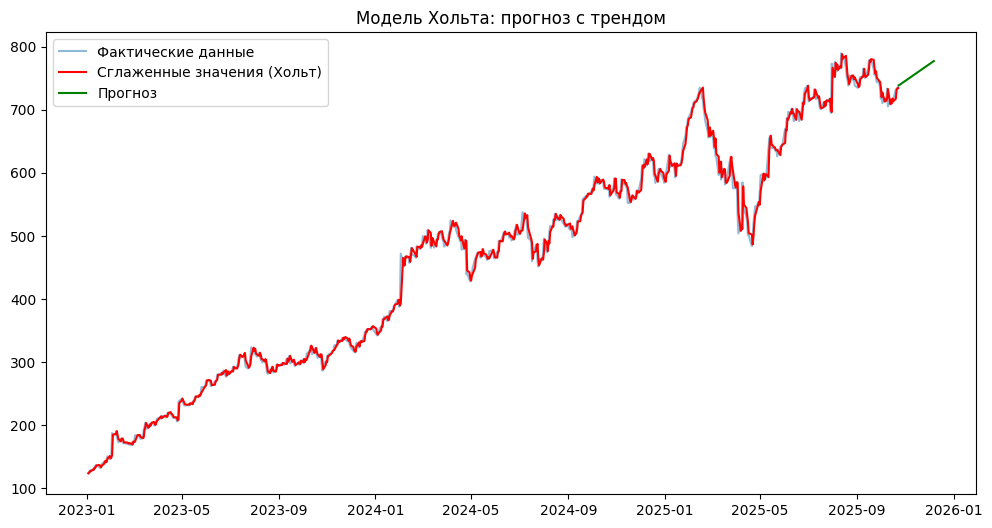

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# тут автоматические подбор коэффициентов благодаря initialization_method="estimated"
model1 = ExponentialSmoothing(data["Close"],  trend="add", seasonal=None, initialization_method="estimated").fit()

print("=== Оптимальные параметры модели Хольта ===")
print(f"α (smoothing_level) = {model1.params['smoothing_level']:.5f}")
print(f"β (smoothing_trend)  = {model1.params['smoothing_trend']:.5f}")
print(f"Начальный уровень    = {model1.params['initial_level']:.2f}")
print(f"Начальный тренд      = {model1.params['initial_trend']:.4f}")

data["SES"] = model1.fittedvalues

days_forward = 45
forecast = model1.forecast(days_forward)

plt.figure(figsize=(12,6))
plt.plot(data.index, data["Close"], label="Фактические данные", alpha=0.5)
plt.plot(data.index, data["SES"], label="Сглаженные значения (Хольт)", color="red")
plt.plot(pd.date_range(data.index[-1]+pd.Timedelta(days=1), periods=days_forward, freq="D"),
         forecast, label="Прогноз", color="green")
plt.legend()
plt.title("Модель Хольта: прогноз с трендом")
plt.show()



=== Оптимальные параметры модели Хольта ===
α (smoothing_level) = 0.50000
β (smoothing_trend)  = 0.50000
Начальный уровень    = 123.13
Начальный тренд      = 1.3482


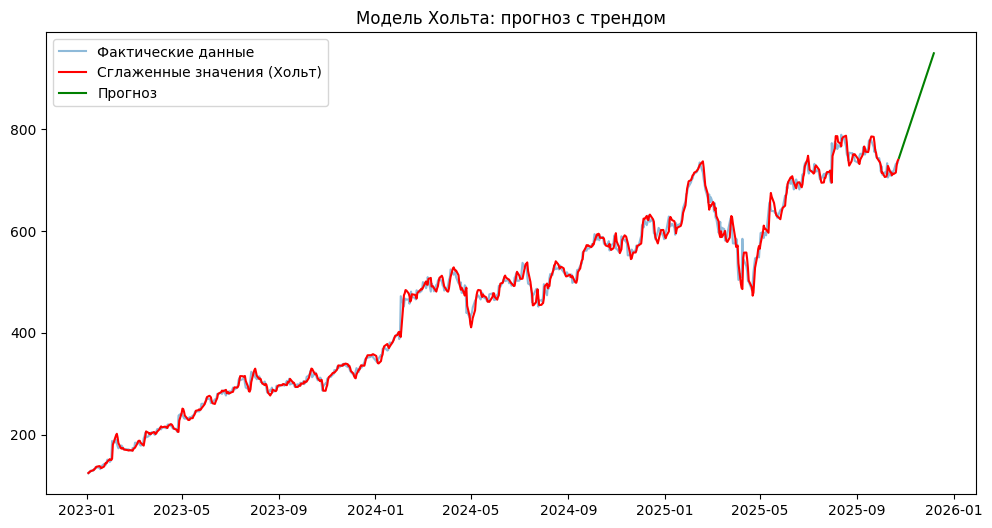

In [10]:

# Пример: фиксированные коэффициенты
alpha = 0.5   # уровень
beta = 0.5    # тренд

model2 = ExponentialSmoothing(
    data["Close"],
    trend="add",
    seasonal=None,
    # initialization_method="known"  # ← важно: при ручных коэффициентах используй "known"
).fit(
    smoothing_level=alpha,
    smoothing_trend=beta,
    optimized=False  # ← отключаем автоматическую оптимизацию!
)

print("=== Оптимальные параметры модели Хольта ===")
print(f"α (smoothing_level) = {model2.params['smoothing_level']:.5f}")
print(f"β (smoothing_trend)  = {model2.params['smoothing_trend']:.5f}")
print(f"Начальный уровень    = {model2.params['initial_level']:.2f}")
print(f"Начальный тренд      = {model2.params['initial_trend']:.4f}")


data["SES"] = model2.fittedvalues
forecast = model2.forecast(45)


plt.figure(figsize=(12,6))
plt.plot(data.index, data["Close"], label="Фактические данные", alpha=0.5)
plt.plot(data.index, data["SES"], label="Сглаженные значения (Хольт)", color="red")
plt.plot(pd.date_range(data.index[-1]+pd.Timedelta(days=1), periods=days_forward, freq="D"),
         forecast, label="Прогноз", color="green")
plt.legend()
plt.title("Модель Хольта: прогноз с трендом")
plt.show()

In [11]:
# Оценка качества модели
print("=== ОЦЕНКА КАЧЕСТВА првой модели ===")
print(f"Сумма квадратов ошибок (SSE): {model1.sse:.2f}")
print(f"Средняя ошибка: {(model1.sse/len(data))**0.5:.2f}")

#
print("=== ОЦЕНКА КАЧЕСТВА второй модели ===")
print(f"Сумма квадратов ошибок (SSE): {model2.sse:.2f}")
print(f"Средняя ошибка: {(model2.sse/len(data))**0.5:.2f}")

=== ОЦЕНКА КАЧЕСТВА првой модели ===
Сумма квадратов ошибок (SSE): 81897.66
Средняя ошибка: 10.78
=== ОЦЕНКА КАЧЕСТВА второй модели ===
Сумма квадратов ошибок (SSE): 112104.11
Средняя ошибка: 12.61


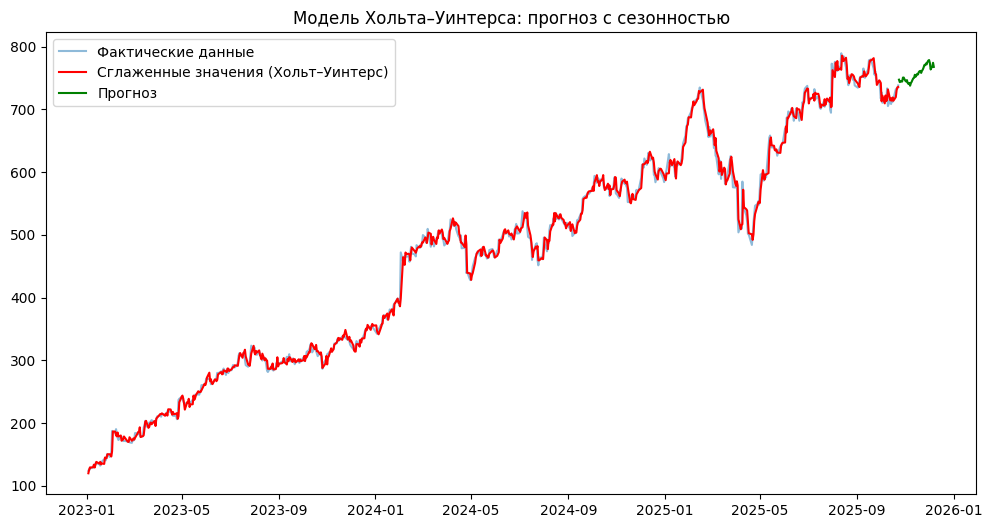

=== ОЦЕНКА КАЧЕСТВА  ===
Сумма квадратов ошибок (SSE): 73445.96
Средняя ошибка: 10.21


In [12]:
days_forward = 45

# Модель Хольта–Уинтерса
hw = ExponentialSmoothing(
    data["Close"],
    trend="add",
    seasonal="add",
    seasonal_periods=60,
    initialization_method="estimated"
).fit()

data["HW"] = hw.fittedvalues
forecast = hw.forecast(days_forward)

# Визуализация
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Close"], label="Фактические данные", alpha=0.5)
plt.plot(data.index, data["HW"], label="Сглаженные значения (Хольт–Уинтерс)", color="red")
plt.plot(pd.date_range(data.index[-1]+pd.Timedelta(days=1), periods=days_forward, freq="D"),
         forecast, label="Прогноз", color="green")
plt.legend()
plt.title("Модель Хольта–Уинтерса: прогноз с сезонностью")
plt.show()


print("=== ОЦЕНКА КАЧЕСТВА  ===")
print(f"Сумма квадратов ошибок (SSE): {hw.sse:.2f}")
print(f"Средняя ошибка: {(hw.sse/len(data))**0.5:.2f}")

In [13]:
for s in (40,60,80,120,150):
    # Модель Хольта–Уинтерса
    hw = ExponentialSmoothing(
        data["Close"],
        trend="add",
        seasonal="add",
        seasonal_periods=s,
        initialization_method="estimated"
    ).fit()
    print(f"Средняя ошибка при seasonal periods = {s}: {(hw.sse/len(data))**0.5:.2f}")

Средняя ошибка при seasonal periods = 40: 10.61
Средняя ошибка при seasonal periods = 60: 10.21
Средняя ошибка при seasonal periods = 80: 10.16
Средняя ошибка при seasonal periods = 120: 9.85
Средняя ошибка при seasonal periods = 150: 9.97


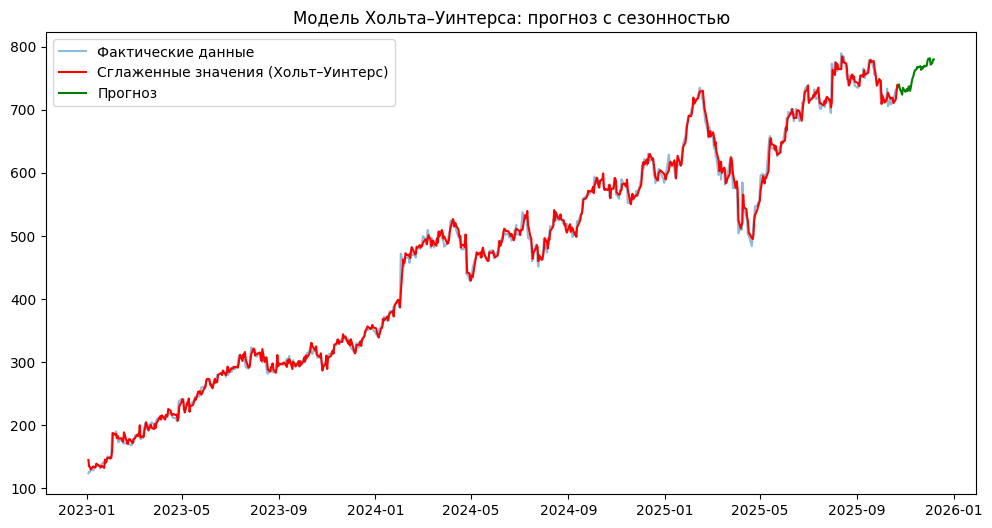

In [14]:
days_forward = 45

# Модель Хольта–Уинтерса
hw = ExponentialSmoothing(
    data["Close"],
    trend="add",
    seasonal="add",
    seasonal_periods=120,
    initialization_method="estimated"
).fit()

data["HW"] = hw.fittedvalues
forecast = hw.forecast(days_forward)

# Визуализация
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Close"], label="Фактические данные", alpha=0.5)
plt.plot(data.index, data["HW"], label="Сглаженные значения (Хольт–Уинтерс)", color="red")
plt.plot(pd.date_range(data.index[-1]+pd.Timedelta(days=1), periods=days_forward, freq="D"),
         forecast, label="Прогноз", color="green")
plt.legend()
plt.title("Модель Хольта–Уинтерса: прогноз с сезонностью")
plt.show()

берем наилучшую модель и на тест оставляем последние 45 дней

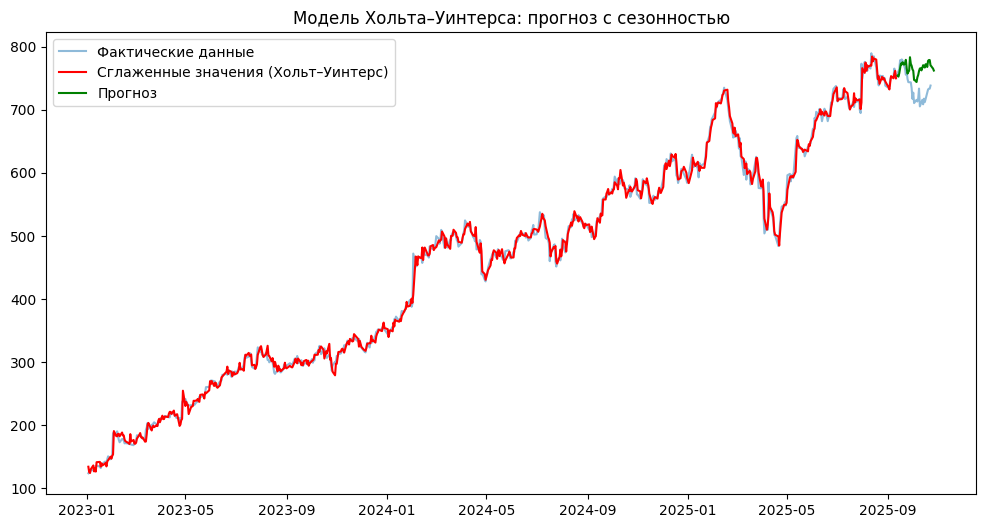

In [16]:
# Модель Хольта–Уинтерса
hw = ExponentialSmoothing(
    data[:-30]["Close"],
    trend="add",
    seasonal="add",
    seasonal_periods=122,
    initialization_method="estimated"
).fit()

data["HW"] = hw.fittedvalues
forecast = hw.forecast(days_forward)

# Визуализация
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Close"], label="Фактические данные", alpha=0.5)
plt.plot(data.index, data["HW"], label="Сглаженные значения (Хольт–Уинтерс)", color="red")
plt.plot(pd.date_range(data.index[-30]+pd.Timedelta(days=1), periods=days_forward, freq="D"),
         forecast, label="Прогноз", color="green")
plt.legend()
plt.title("Модель Хольта–Уинтерса: прогноз с сезонностью")
plt.show()

разобраться с forecast и predict, попробовать мультипликативную модель, и там тоже найти оптимальный параметр seasons, оценить на тестовом множестве - последние 45 дней

# Семинар 10

построить пайплайн подбора наиболее оптимальной модели

Прогноз на следующие 5 периодов

pred1 = fit.forecast(steps=5)

То же самое через predict

pred2 = fit.predict(start=len(data), end=len(data)+4)  # индексы с 100 по 104

если надо получить прогноз на последние 10 точек внутри выборки (для backtesting):

Только predict позволяет это сделать

in_sample_pred = fit.predict(start=90, end=99)

forecast(steps=10) не даст такого — он всегда идёт вперёд от конца выборки

будем проверять на тех значениях, которые не входили в обучение, и это последние 45 дней

тестируем мультипликативную модель

In [17]:
for s in (40,60,80,120,150):
    # Модель Хольта–Уинтерса
    hw = ExponentialSmoothing(
        data["Close"],
        trend="multiplicative",
        seasonal="multiplicative",
        seasonal_periods=s,
        initialization_method="estimated"
    ).fit()
    print(f"Средняя ошибка при seasonal periods = {s}: {(hw.sse/len(data))**0.5:.2f}")

Средняя ошибка при seasonal periods = 40: 10.55
Средняя ошибка при seasonal periods = 60: 10.07
Средняя ошибка при seasonal periods = 80: 10.01
Средняя ошибка при seasonal periods = 120: 9.80
Средняя ошибка при seasonal periods = 150: 9.80


In [18]:
for s in (40,60,80,120,150):
    # Модель Хольта–Уинтерса
    hw = ExponentialSmoothing(
        data["Close"],
        trend="add",
        seasonal="multiplicative",
        seasonal_periods=s,
        initialization_method="estimated"
    ).fit()
    print(f"Средняя ошибка при seasonal periods = {s}: {(hw.sse/len(data))**0.5:.2f}")

Средняя ошибка при seasonal periods = 40: 10.53
Средняя ошибка при seasonal periods = 60: 10.11
Средняя ошибка при seasonal periods = 80: 9.99
Средняя ошибка при seasonal periods = 120: 9.54
Средняя ошибка при seasonal periods = 150: 9.55


In [19]:
for s in (40,60,80,120,150):
    # Модель Хольта–Уинтерса
    hw = ExponentialSmoothing(
        data["Close"],
        trend="multiplicative",
        seasonal="add",
        seasonal_periods=s,
        initialization_method="estimated"
    ).fit()
    print(f"Средняя ошибка при seasonal periods = {s}: {(hw.sse/len(data))**0.5:.2f}")

Средняя ошибка при seasonal periods = 40: 10.63
Средняя ошибка при seasonal periods = 60: 10.26
Средняя ошибка при seasonal periods = 80: 10.19
Средняя ошибка при seasonal periods = 120: 9.91
Средняя ошибка при seasonal periods = 150: 10.05


Наилучший результат у модели Хольта - Уинтерса с аддитивным трендом и мультипликативной сезонностью

Хотим обучать на всем множестве, кроме последних 2 месяцев (в выборке это 40 записей), и потом на них протестить

In [22]:
data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SES,SES_0.1,SES_0.5,SES_0.9,HW
Date,,,,,,,,,,,,
2025-10-17 00:00:00-04:00,707.080017,718.539978,706.119995,716.919983,12232400,0.0,0.0,712.024395,726.471603,713.432904,712.535282,NaN
2025-10-20 00:00:00-04:00,721.190002,733.770020,720.179993,732.169983,8900200,0.0,0.0,715.052610,725.516441,715.176443,716.481513,NaN
2025-10-21 00:00:00-04:00,736.020020,738.500000,728.750000,733.270020,7647300,0.0,0.0,728.471061,726.181795,723.673213,730.601136,NaN
2025-10-22 00:00:00-04:00,733.830017,740.599976,724.030029,733.409973,8712800,0.0,0.0,736.930044,726.890617,728.471616,733.003131,NaN
2025-10-23 00:00:00-04:00,734.700012,742.409973,733.479980,738.320007,2660910,0.0,0.0,740.349495,727.542553,730.940795,733.369289,NaN


In [21]:
days_forward = 40

data[:-days_forward].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SES,SES_0.1,SES_0.5,SES_0.9,HW
Date,,,,,,,,,,,,
2025-08-14 00:00:00-04:00,777.355345,787.278640,771.988971,781.602478,8116200,0.0,0.0,783.954246,749.327704,778.601397,780.306859,776.712730
2025-08-15 00:00:00-04:00,783.621151,795.712965,780.293380,784.700378,13375400,0.0,0.0,785.413703,752.555181,780.101938,781.472916,781.166106
2025-08-18 00:00:00-04:00,774.567242,775.286727,756.049711,766.852417,16513700,0.0,0.0,787.514050,755.769701,782.401158,784.377632,779.526796
2025-08-19 00:00:00-04:00,766.602611,766.652565,748.854579,750.973145,12286700,0.0,0.0,774.474835,756.877973,774.626787,768.604939,763.901617
2025-08-20 00:00:00-04:00,747.065775,749.694006,730.506944,747.215637,11898200,0.0,0.0,754.140168,756.287490,762.799966,752.736324,748.297908


In [23]:
# Модель Хольта–Уинтерса
hw = ExponentialSmoothing(
    data[:-days_forward]["Close"],
    trend="add",
    seasonal="multiplicative",
    seasonal_periods=120,
    initialization_method="estimated"
).fit()

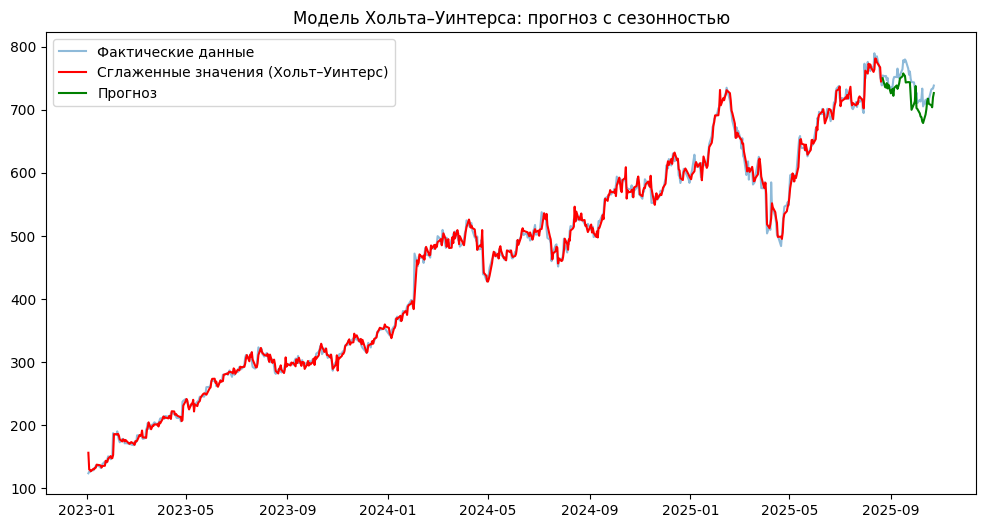

In [25]:
business_freq = pd.offsets.BDay()

data["HW"] = hw.fittedvalues
forecast = hw.forecast(days_forward)

# Создаем индекс для прогноза только с рабочими днями
forecast_index = pd.date_range(start=data.index[-days_forward] + business_freq,
                              periods=days_forward,
                              freq=business_freq)

# Визуализация
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Close"], label="Фактические данные", alpha=0.5)
plt.plot(data.index, data["HW"], label="Сглаженные значения (Хольт–Уинтерс)", color="red")
plt.plot(forecast_index,  forecast, label="Прогноз", color="green")
plt.legend()
plt.title("Модель Хольта–Уинтерса: прогноз с сезонностью")
plt.show()

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


actual_test = data[-days_forward:]["Close"]


# Метрики качества
mae = mean_absolute_error(actual_test, forecast)
mse = mean_squared_error(actual_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_test.values - forecast.values) / actual_test.values)) * 100

print("ОЦЕНКА КАЧЕСТВА ПРОГНОЗА НА ТЕСТОВОЙ ВЫБОРКЕ (60 ДНЕЙ):")
print("=" * 60)
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.1f}%")

ОЦЕНКА КАЧЕСТВА ПРОГНОЗА НА ТЕСТОВОЙ ВЫБОРКЕ (60 ДНЕЙ):
MAE:  18.76
RMSE: 21.51
MAPE: 2.5%


In [30]:
len(actual_test)

45

In [29]:
len(forecast)

45

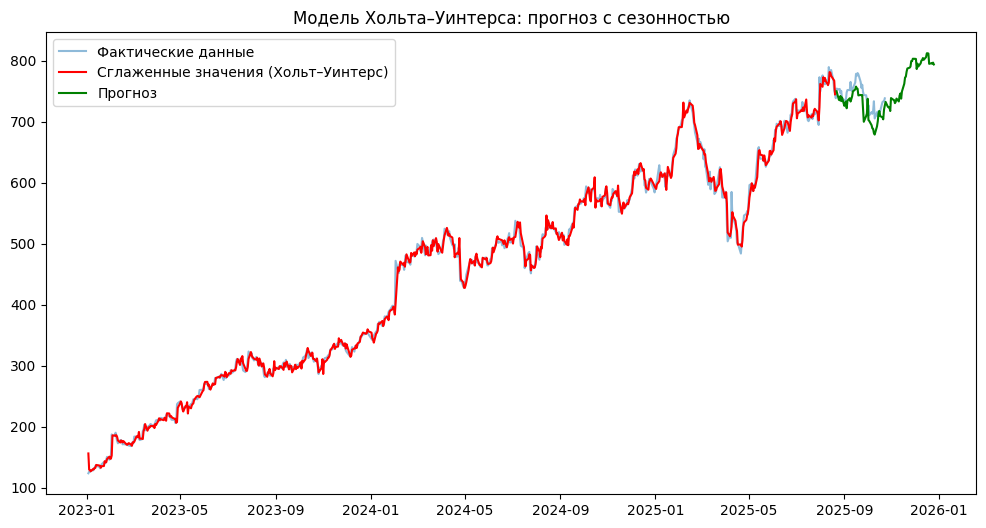

In [38]:
business_freq = pd.offsets.BDay()

data["HW"] = hw.fittedvalues
forecast = hw.forecast(days_forward*2)

# Создаем индекс для прогноза только с рабочими днями
forecast_index = pd.date_range(start=data.index[-days_forward] + business_freq,
                              periods=days_forward*2,
                              freq=business_freq)

# Визуализация
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Close"], label="Фактические данные", alpha=0.5)
plt.plot(data.index, data["HW"], label="Сглаженные значения (Хольт–Уинтерс)", color="red")
plt.plot(forecast_index,  forecast, label="Прогноз", color="green")
plt.legend()
plt.title("Модель Хольта–Уинтерса: прогноз с сезонностью")
plt.show()

тогда начинаем строить пайплайн выбора наилучшей модели и ее параметров

выберем RMSE и без отложенной тестовой выборки

тогда будем перебирать модели Хольта Уинтерса, менять период сезонности, менять типы тренда и сезонности

In [63]:
def build_model(data,trend, seasonal, seasonal_periods):
  # Модель Хольта–Уинтерса
  hw = ExponentialSmoothing(
      data["Close"],
      trend=trend,
      seasonal=seasonal,
      seasonal_periods=seasonal_periods,
      initialization_method="estimated"
  ).fit()
  return hw

In [45]:
best_score = data["Close"][-1]
best_score

np.float64(738.3200073242188)

In [55]:
from tqdm import tqdm

In [64]:
def grid_search_exp_smooth(data,seasons_list):
    best_score = data["Close"][-1]
    best_seasons_period = None
    best_model = None
    best_type_trend = None
    best_type_seasonal = None
    type_variants = ('add', 'mul')
    for seasonal_period in tqdm(seasons_list, desc = 'Перебор периода сезонности'):
       for seasonal in type_variants:
         for trend in type_variants:
            model = build_model(data,trend, seasonal, seasonal_period)
            currents_score = (model.sse/len(data))**0.5
            print(f"текущая модель при типе тренда {trend}, типе сезонности {seasonal}, \
периоду сезонности {seasonal_period}, rmse = {currents_score}")
            if currents_score < best_score:
                best_score = currents_score
                best_seasons_period = seasonal_period
                best_model = model
                best_type_trend = trend
                best_type_seasonal = seasonal
    print("------------------------------------")
    print(f"Лучшая модель при типе тренда {best_type_trend}, типе сезонности {best_type_seasonal}, \
периоду сезонности {best_seasons_period}, rmse = {best_score}")
    return best_model

In [61]:
def plot_best_forecast():
    seasons_list = [i for i in range(80,151,20)]
    best_model = grid_search_exp_smooth(data,seasons_list)
    # Визуализация
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data["Close"], label="Фактические данные", alpha=0.5)
    plt.plot(data.index, best_model.fittedvalues, label="Сглаженные значения (Хольт–Уинтерс)", color="red")
    plt.legend()
    plt.title("Лучшая Модель Хольта–Уинтерса")
    plt.show()


Перебор периода сезонности:   0%|          | 0/4 [00:00<?, ?it/s]

текущая модель при типе тренда add, типе сезонности add, периоду сезонности 80, rmse = 10.161295071571432
текущая модель при типе тренда mul, типе сезонности add, периоду сезонности 80, rmse = 10.191421532646247
текущая модель при типе тренда add, типе сезонности mul, периоду сезонности 80, rmse = 9.993665738687863


Перебор периода сезонности:  25%|██▌       | 1/4 [00:07<00:23,  7.70s/it]

текущая модель при типе тренда mul, типе сезонности mul, периоду сезонности 80, rmse = 10.00758939506518
текущая модель при типе тренда add, типе сезонности add, периоду сезонности 100, rmse = 10.209507269312967
текущая модель при типе тренда mul, типе сезонности add, периоду сезонности 100, rmse = 10.269524308155521
текущая модель при типе тренда add, типе сезонности mul, периоду сезонности 100, rmse = 9.899276963467514


Перебор периода сезонности:  50%|█████     | 2/4 [00:16<00:16,  8.45s/it]

текущая модель при типе тренда mul, типе сезонности mul, периоду сезонности 100, rmse = 10.08656163463113
текущая модель при типе тренда add, типе сезонности add, периоду сезонности 120, rmse = 9.848352214630312
текущая модель при типе тренда mul, типе сезонности add, периоду сезонности 120, rmse = 9.907986124231874
текущая модель при типе тренда add, типе сезонности mul, периоду сезонности 120, rmse = 9.537883870921478


Перебор периода сезонности:  75%|███████▌  | 3/4 [00:25<00:08,  8.62s/it]

текущая модель при типе тренда mul, типе сезонности mul, периоду сезонности 120, rmse = 9.79631403454035
текущая модель при типе тренда add, типе сезонности add, периоду сезонности 140, rmse = 10.01995185824578
текущая модель при типе тренда mul, типе сезонности add, периоду сезонности 140, rmse = 10.095047536377786
текущая модель при типе тренда add, типе сезонности mul, периоду сезонности 140, rmse = 9.898446641854068


Перебор периода сезонности: 100%|██████████| 4/4 [00:33<00:00,  8.41s/it]

текущая модель при типе тренда mul, типе сезонности mul, периоду сезонности 140, rmse = 9.988150050922563
------------------------------------
Лучшая модель при типе тренда add, типе сезонности mul, периоду сезонности 120, rmse = 9.537883870921478


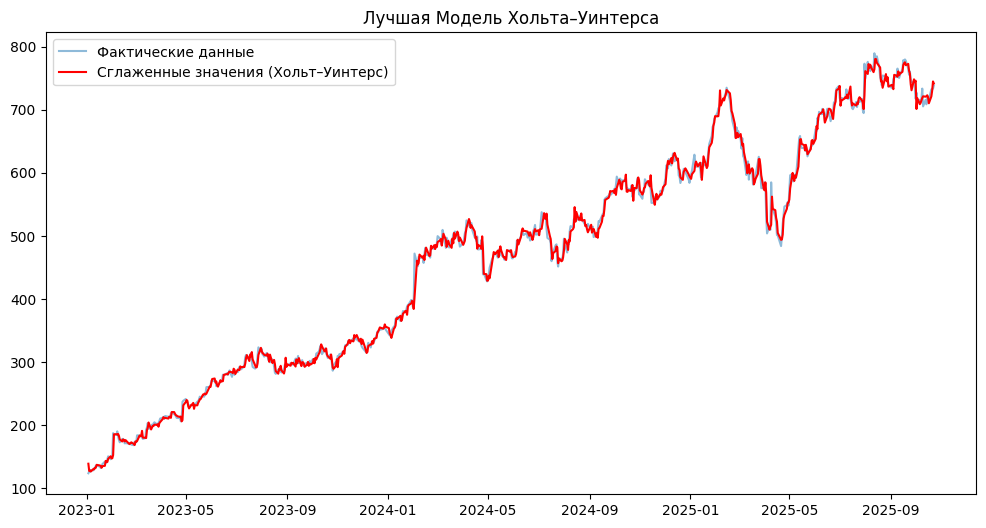

In [62]:
plot_best_forecast()

In [65]:
def plot_best_forecast(ticker_name):
    meta = yf.Ticker(ticker_name)
    data = meta.history(period="max")
    seasons_list = [i for i in range(80,151,20)]
    best_model = grid_search_exp_smooth(data, seasons_list)
    # Визуализация
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data["Close"], label="Фактические данные", alpha=0.5)
    plt.plot(data.index, best_model.fittedvalues, label="Сглаженные значения (Хольт–Уинтерс)", color="red")
    plt.legend()
    plt.title("Лучшая Модель Хольта–Уинтерса")
    plt.show()

In [66]:
plot_best_forecast('AAPL')

Перебор периода сезонности:   0%|          | 0/4 [00:00<?, ?it/s]

текущая модель при типе тренда add, типе сезонности add, периоду сезонности 80, rmse = 1.0996094779074246
текущая модель при типе тренда mul, типе сезонности add, периоду сезонности 80, rmse = 1.1007390601021778
текущая модель при типе тренда add, типе сезонности mul, периоду сезонности 80, rmse = 1.1074241494605646


Перебор периода сезонности:   0%|          | 0/4 [01:14<?, ?it/s]


KeyboardInterrupt: 